In [21]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
cal = pd.read_csv(r"C:\Users\hwoo2\Desktop\pandas\Freedom debt relief project\calendar_data.csv")
client = pd.read_csv(r"C:\Users\hwoo2\Desktop\pandas\Freedom debt relief project\client_data.csv")
dep = pd.read_csv(r"C:\Users\hwoo2\Desktop\pandas\Freedom debt relief project\deposit_data.csv")


In [23]:
# overview of the datasets I'm working with
print(cal.shape, client.shape, dep.shape)
client.sample(5)
cal.sample(5)
dep.sample(5)

(153, 2) (46347, 4) (480394, 5)


,client_id,deposit_type,deposit_amount,deposit_cadence,deposit_date
257588,97163582346653,Scheduled Deposit,381.0,Monthly,2019-08-28
90806,111903407347394,Scheduled Deposit,430.0,Monthly,2019-10-19
415759,66285892221918,Actual Deposit,442.0,Monthly,2019-09-15
56383,813841288695605,Actual Deposit,173.0,Biweekly,2019-08-19
200367,588165443712500,Scheduled Deposit,283.0,Biweekly,2019-08-06


In [25]:
# join tables for analysis
client_trans = client.merge(right = dep, how = 'right', on = 'client_id').sort_values(by = ['client_id','deposit_date'])
agg_tbl = client_trans.merge(right = cal, how = 'inner', left_on = 'deposit_date', right_on = 'gregorian_date',) \
    .drop(labels = 'gregorian_date',axis = 1)

agg_tbl.sample(5)

,client_id,client_geographical_region,client_residence_status,client_age,deposit_type,deposit_amount,deposit_cadence,deposit_date,month_name
222575,243739913823465,Northeast,Own,33,Actual Deposit,322.0,Monthly,2019-08-16,Month 3
479335,254332168171068,West,Rent,54,Actual Deposit,544.0,Monthly,2019-06-02,Month 1
244109,564245576888066,Midwest,Own,59,Actual Deposit,250.0,Biweekly,2019-10-30,Month 5
246513,97163582346653,West,Rent,51,Actual Deposit,272.0,Monthly,2019-06-28,Month 1
297443,982017032187673,West,Rent,49,Actual Deposit,296.0,Monthly,2019-08-05,Month 3


In [32]:
# clean up data to process more efficiently

print(agg_tbl.info())
agg_tbl['deposit_date'] = pd.to_datetime(agg_tbl['deposit_date'])

agg_tbl[['client_geographical_region','client_residence_status','deposit_type','deposit_cadence','month_name']] \
 = agg_tbl[['client_geographical_region','client_residence_status','deposit_type','deposit_cadence','month_name']] \
.astype('category')

print(agg_tbl.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 480394 entries, 0 to 480393
Data columns (total 9 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   client_id                   480394 non-null  int64         
 1   client_geographical_region  480394 non-null  category      
 2   client_residence_status     480394 non-null  category      
 3   client_age                  480394 non-null  int64         
 4   deposit_type                480394 non-null  category      
 5   deposit_amount              480394 non-null  float64       
 6   deposit_cadence             480394 non-null  category      
 7   deposit_date                480394 non-null  datetime64[ns]
 8   month_name                  480394 non-null  category      
dtypes: category(5), datetime64[ns](1), float64(1), int64(2)
memory usage: 36.7 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 480394 entries, 0 to 480393
Data colu

In [33]:
# EDA for general understanding of what's happening

# What's the breakout of different regions, residence statuses, ages, amounts deposited, and cadence

#typical customer is 40-60 and makes deposits of $200-$50
print(agg_tbl.describe())
print(agg_tbl['client_id'].nunique())

# 42% are westerners, 22% are southerners, MW and NE are 18 and 16% respectively
agg_tbl['client_geographical_region'].value_counts(normalize = True) 

#strangely enough, 72% of the clients own property; might be a byproduct of their age, not indicative of their fin. status
agg_tbl['client_residence_status'].value_counts(normalize = True) 

# no surprises here, ~98% of deposits are automated rather than extra; 55% are monthly and 44% are biweekly
agg_tbl['deposit_cadence'].value_counts(normalize = True) 

          client_id     client_age  deposit_amount
count  4.803940e+05  480394.000000   480394.000000
mean   4.992809e+14      52.192469      365.207130
std    2.899833e+14      13.773928      346.644434
min    1.460463e+11      21.000000        0.010000
25%    2.477689e+14      41.000000      200.000000
50%    5.015297e+14      52.000000      290.000000
75%    7.503108e+14      62.000000      452.000000
max    9.999856e+14     105.000000    30000.000000
46347


Monthly     0.547172
Biweekly    0.435453
Extra       0.017375
Name: deposit_cadence, dtype: float64

In [34]:
#timeframe of analysis is in summer/fall of 2019
print(agg_tbl['deposit_date'].max(), ",",agg_tbl['deposit_date'].min())

2019-10-31 00:00:00 , 2019-06-01 00:00:00


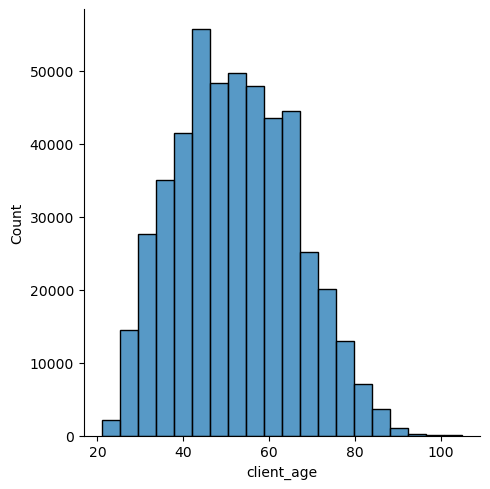

In [35]:
# Plot a histogram of a client age to understand customer base better
sns.displot(data=agg_tbl, x=agg_tbl['client_age'], kind = 'hist', bins = 20)
plt.show()

In [36]:
#program generally works; 23.2/24.8k acutal deposits vs scheduled
agg_tbl['deposit_type'].value_counts()

Scheduled Deposit    247986
Actual Deposit       232408
Name: deposit_type, dtype: int64

In [37]:
agg_tbl['deposit_cadence'].value_counts()

Monthly     262858
Biweekly    209189
Extra         8347
Name: deposit_cadence, dtype: int64

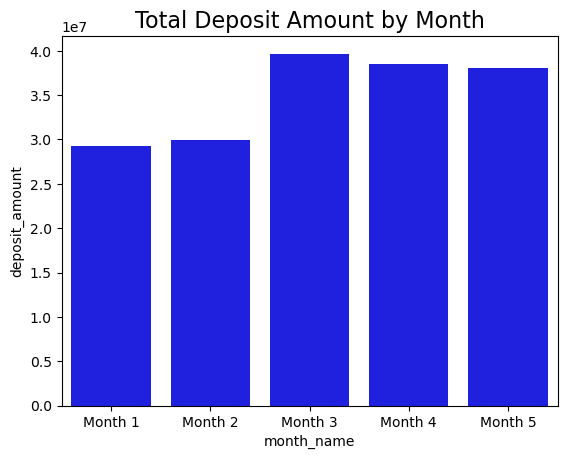

In [38]:
# check changes in total $ deposits over time 
mth_dep_amt = agg_tbl.groupby(agg_tbl['month_name'])['deposit_amount'].sum()

mth_dep_amt = mth_dep_amt.to_frame().reset_index()

sns.barplot(data=mth_dep_amt, x=mth_dep_amt['month_name'], y=mth_dep_amt['deposit_amount'], color="blue")
plt.title('Total Deposit Amount by Month', fontsize =16)
plt.show()


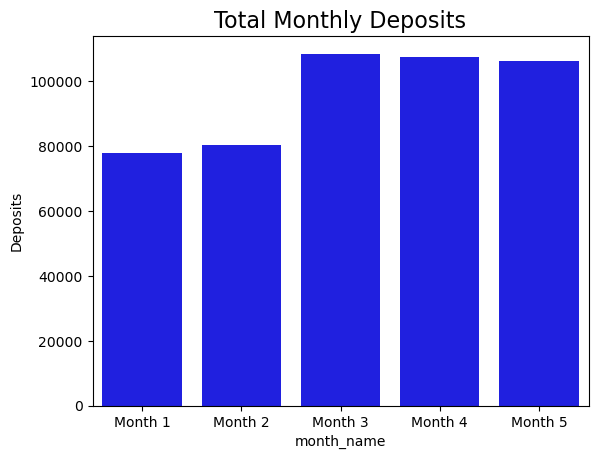

In [39]:
#check changes in total # deposits over time 

mth_dep_ct = agg_tbl.groupby(agg_tbl['month_name'])['deposit_amount'].size()

mth_dep_ct = mth_dep_ct.to_frame().reset_index()

sns.barplot(data=mth_dep_ct, x=mth_dep_ct['month_name'], y=mth_dep_ct['deposit_amount'], color="blue")
plt.title('Total Monthly Deposits', fontsize =16)
plt.ylabel('Deposits')
plt.show()


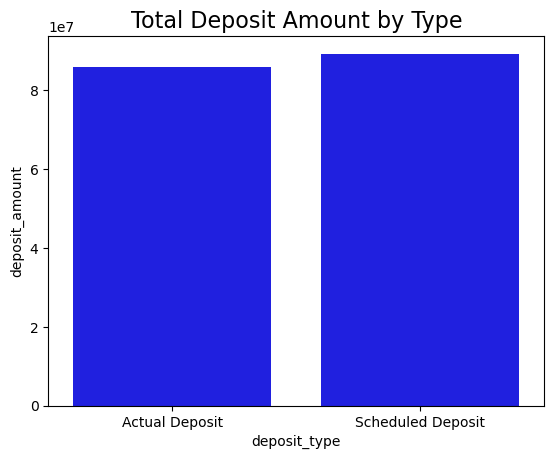

In [41]:
#check total deposit scheduled vs actual total deposits

mth_dep_type_amt = agg_tbl.groupby(agg_tbl['deposit_type'])['deposit_amount'].sum()

mth_dep_type_amt = mth_dep_type_amt.to_frame().reset_index()

sns.barplot(data=mth_dep_type_amt, x=mth_dep_type_amt['deposit_type'], y=mth_dep_type_amt['deposit_amount'], color="blue")
plt.title('Total Deposit Amount by Type', fontsize =16)
plt.show()


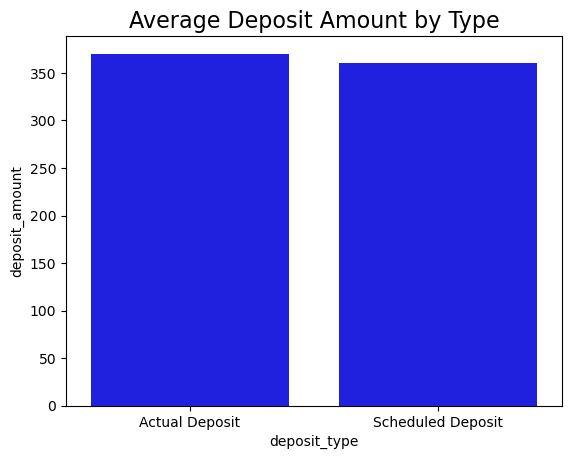

In [42]:
#check typical deposit scheduled vs actual average deposit

mth_dep_type_ct = agg_tbl.groupby(agg_tbl['deposit_type'])['deposit_amount'].mean()

mth_dep_type_ct = mth_dep_type_ct.to_frame().reset_index()

sns.barplot(data=mth_dep_type_ct, x=mth_dep_type_ct['deposit_type'], y=mth_dep_type_ct['deposit_amount'], color="blue")
plt.title('Average Deposit Amount by Type', fontsize =16)
plt.show()


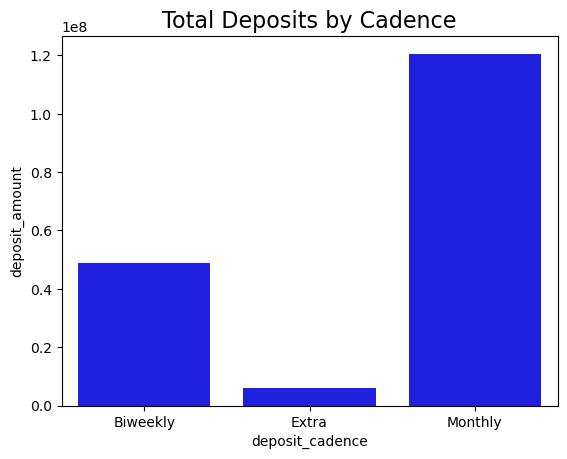

In [43]:
#check $ deposits by cadence

mth_dep_cadence_amt = agg_tbl.groupby(agg_tbl['deposit_cadence'])['deposit_amount'].sum()

mth_dep_cadence_amt = mth_dep_cadence_amt.to_frame().reset_index()

sns.barplot(data=mth_dep_cadence_amt, x=mth_dep_cadence_amt['deposit_cadence'], y=mth_dep_cadence_amt['deposit_amount'], color="blue")
plt.title('Total Deposits by Cadence', fontsize =16)
plt.show()

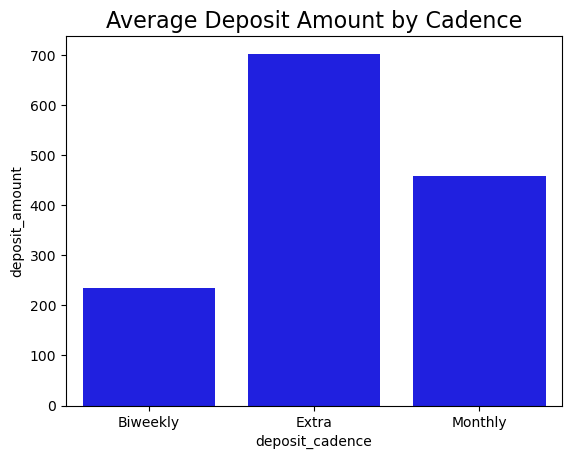

In [44]:
#check average $ deposits by type

mth_dep_cadence_ct = agg_tbl.groupby(agg_tbl['deposit_cadence'])['deposit_amount'].mean()

mth_dep_cadence_ct = mth_dep_cadence_ct.to_frame().reset_index()

sns.barplot(data=mth_dep_cadence_ct, x=mth_dep_cadence_ct['deposit_cadence'], y=mth_dep_cadence_ct['deposit_amount'], color="blue")
plt.title('Average Deposit Amount by Cadence', fontsize =16)
plt.show()

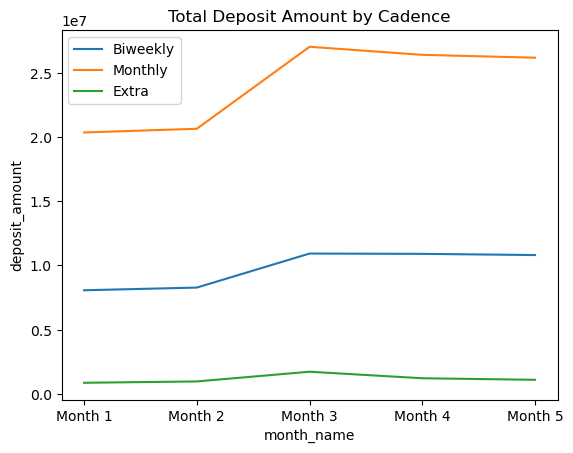

In [45]:
#Check deposit amounts over time based on cadence
depamt_overtime_cadence = agg_tbl.groupby([agg_tbl['deposit_cadence'],agg_tbl['month_name']])['deposit_amount'].sum()

depamt_overtime_cadence = depamt_overtime_cadence.to_frame().reset_index()

# Plot a line graph with 3 lines
sns.lineplot(data=depamt_overtime_cadence, x=depamt_overtime_cadence['month_name'], y=depamt_overtime_cadence[depamt_overtime_cadence['deposit_cadence'] == 'Biweekly']['deposit_amount'])
sns.lineplot(data=depamt_overtime_cadence, x=depamt_overtime_cadence['month_name'], y=depamt_overtime_cadence[depamt_overtime_cadence['deposit_cadence'] == 'Monthly']['deposit_amount'])
sns.lineplot(data=depamt_overtime_cadence, x=depamt_overtime_cadence['month_name'], y=depamt_overtime_cadence[depamt_overtime_cadence['deposit_cadence'] == 'Extra']['deposit_amount'])


# Add a title to the graph
plt.title("Total Deposit Amount by Cadence")

# Add a legend to the graph
plt.legend(labels=["Biweekly", "Monthly", "Extra"])

plt.show()


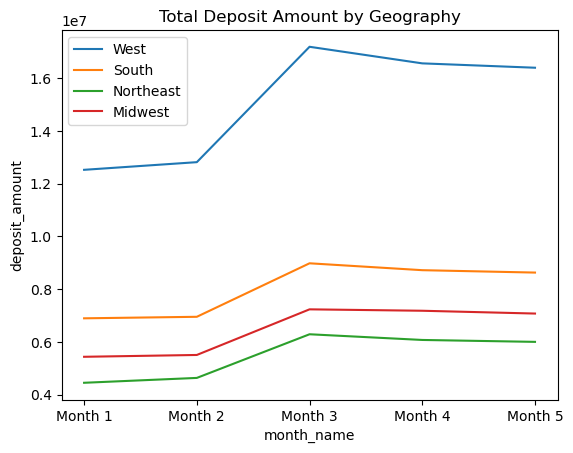

In [46]:
#Check amts over time based on geography
depamt_overtime_geo = agg_tbl.groupby([agg_tbl['client_geographical_region'],agg_tbl['month_name']])['deposit_amount'].sum()

depamt_overtime_geo = depamt_overtime_geo.to_frame().reset_index()

# Plot a line graph with 3 lines
sns.lineplot(data=depamt_overtime_geo, x=depamt_overtime_geo['month_name'], y=depamt_overtime_geo[depamt_overtime_geo['client_geographical_region'] == 'West']['deposit_amount'])
sns.lineplot(data=depamt_overtime_geo, x=depamt_overtime_geo['month_name'], y=depamt_overtime_geo[depamt_overtime_geo['client_geographical_region'] == 'South']['deposit_amount'])
sns.lineplot(data=depamt_overtime_geo, x=depamt_overtime_geo['month_name'], y=depamt_overtime_geo[depamt_overtime_geo['client_geographical_region'] == 'Northeast']['deposit_amount'])
sns.lineplot(data=depamt_overtime_geo, x=depamt_overtime_geo['month_name'], y=depamt_overtime_geo[depamt_overtime_geo['client_geographical_region'] == 'Midwest']['deposit_amount'])


# Add a title to the graph
plt.title("Total Deposit Amount by Geography")

# Add a legend to the graph
plt.legend(labels=["West", "South", "Northeast","Midwest"])

plt.show()


In [47]:
depamt_overtime_cadence

,deposit_cadence,month_name,deposit_amount
0,Biweekly,Month 1,8067092.64
1,Biweekly,Month 2,8276132.98
2,Biweekly,Month 3,10924866.19
3,Biweekly,Month 4,10901797.30
4,Biweekly,Month 5,10809396.84
5,Extra,Month 1,862681.06
6,Extra,Month 2,967124.39
7,Extra,Month 3,1723684.35
8,Extra,Month 4,1215140.53
9,Extra,Month 5,1094136.23


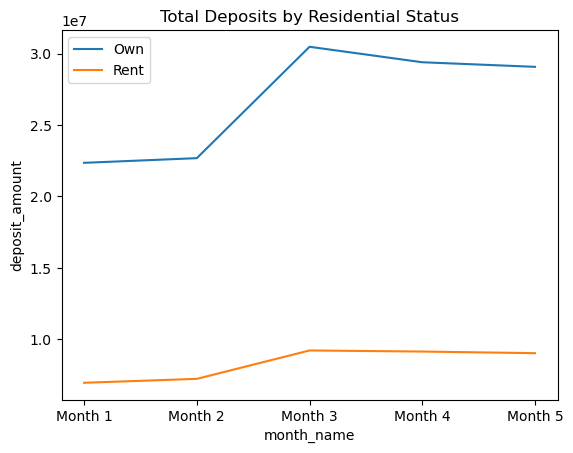

In [48]:
#Check deposit amts over time based on residential status
depamt_overtime_res = agg_tbl.groupby([agg_tbl['client_residence_status'],agg_tbl['month_name']])['deposit_amount'].sum()

depamt_overtime_res = depamt_overtime_res.to_frame().reset_index()

# Plot a line graph with 3 lines
sns.lineplot(data=depamt_overtime_res, x=depamt_overtime_res['month_name'], y=depamt_overtime_res[depamt_overtime_res['client_residence_status'] == 'Own']['deposit_amount'])
sns.lineplot(data=depamt_overtime_res, x=depamt_overtime_res['month_name'], y=depamt_overtime_res[depamt_overtime_res['client_residence_status'] == 'Rent']['deposit_amount'])


# Add a title to the graph
plt.title("Total Deposits by Residential Status")

# Add a legend to the graph
plt.legend(labels=["Own", "Rent"])

plt.show()


In [49]:
mth_dep_ct = mth_dep_ct.rename(columns = {'deposit_amount':'deposits'})
pd.merge(mth_dep_amt,mth_dep_ct)


,month_name,deposit_amount,deposits
0,Month 1,29284830.86,77827
1,Month 2,29886431.27,80205
2,Month 3,39675057.10,108505
3,Month 4,38515819.73,107494
4,Month 5,38081175.23,106363


### 1). Provide a quantitative assessment of whether the marketing campaign was successful. How and why did you choose your specific success metric(s)?

The campaign was not successful, as it led to a net loss of 200K dollars while increasing the number of deposits that have to be managed

1a. there was a notable increase in deposits across all cadences, regions, and residential statuses in month 3 vs month 2, and stayed above the month 2 baseline

1b. The number of deposits increased 35% (+28k) MoM; The total value of deposits increased 33% (+9.8M) MoM

1c. The average number of deposits after the campaign was 36% higher than prior to the campaign when comparing the average number of deposits in month 1 and 2 vs months 3-5

1d. While the campaign cost 5M dollars, it generated about 26.5M dollars in increased deposits across months 3-5 when compared to the month 2 baseline deposit amount of about 30M dollars. However, according to the company's website (18% fees on deposits returned), this is only a gross profit of 4.8M dollars, and thus, an net loss of over 200K dollars


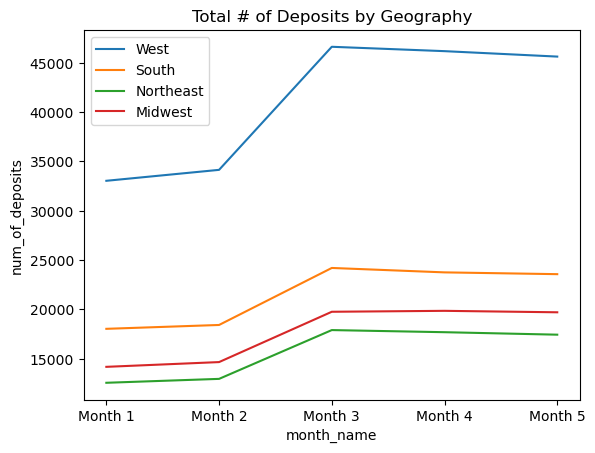

In [50]:
#Check # deposits over time
gp = agg_tbl.groupby([agg_tbl['client_geographical_region'],agg_tbl['month_name']])['deposit_amount'].size()

gp = gp.to_frame().reset_index()

gp = gp.rename(columns = {'deposit_amount':'num_of_deposits'})

# Plot a line graph with 3 lines
sns.lineplot(data=gp, x=gp['month_name'], y=gp[gp['client_geographical_region'] == 'West']['num_of_deposits'])
sns.lineplot(data=gp, x=gp['month_name'], y=gp[gp['client_geographical_region'] == 'South']['num_of_deposits'])
sns.lineplot(data=gp, x=gp['month_name'], y=gp[gp['client_geographical_region'] == 'Northeast']['num_of_deposits'])
sns.lineplot(data=gp, x=gp['month_name'], y=gp[gp['client_geographical_region'] == 'Midwest']['num_of_deposits'])


# Add a title to the graph
plt.title("Total # of Deposits by Geography")

# Modify y axis label
#lbl.set_ylabel("# of deposits")

# Add a legend to the graph
plt.legend(labels=["West", "South", "Northeast","Midwest"])

plt.show()


In [51]:
gp

,client_geographical_region,month_name,num_of_deposits
0,Midwest,Month 1,14183
1,Midwest,Month 2,14665
2,Midwest,Month 3,19765
3,Midwest,Month 4,19860
4,Midwest,Month 5,19712
5,Northeast,Month 1,12567
6,Northeast,Month 2,12963
7,Northeast,Month 3,17909
8,Northeast,Month 4,17694
9,Northeast,Month 5,17443


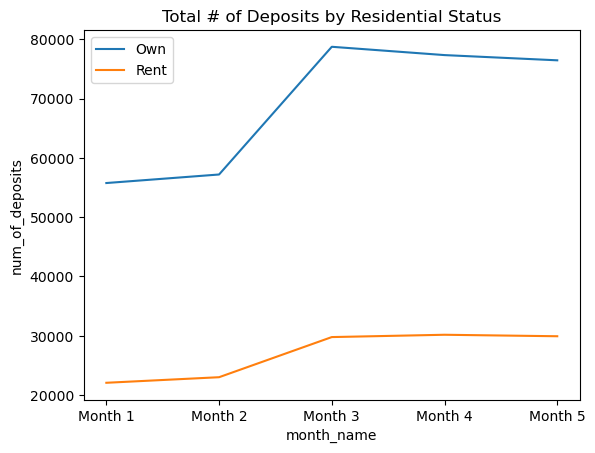

In [53]:
#Check # deposits over time based on cadence
gp = agg_tbl.groupby([agg_tbl['client_residence_status'],agg_tbl['month_name']])['deposit_amount'].size()

gp = gp.to_frame().reset_index()

gp = gp.rename(columns = {'deposit_amount':'num_of_deposits'})

# Plot a line graph with 3 lines
sns.lineplot(data=gp, x=gp['month_name'], y=gp[gp['client_residence_status'] == 'Own']['num_of_deposits'])
sns.lineplot(data=gp, x=gp['month_name'], y=gp[gp['client_residence_status'] == 'Rent']['num_of_deposits'])


# Add a title to the graph
plt.title("Total # of Deposits by Residential Status")

# Add a legend to the graph
plt.legend(labels=["Own", "Rent"])

plt.show()


In [54]:
gp = agg_tbl.groupby(agg_tbl['client_residence_status'])['deposit_amount'].mean()

gp

client_residence_status
Own     387.748333
Rent    307.513464
Name: deposit_amount, dtype: float64

### 2). Based on the provided data, how would you recommend campaign strategy be adjusted in the future to improve performance?

Campaign strategy could be improved by re-running a more focused campaign target on homeowners 40 and older, which would result in a more efficient allocation of capital 

2a. Customers over 40 represented the largest shared of customers with Freedom Debt Relief

2b. In general, customers had higher $ deposits the older they got, but those under 40 had a much lower average deposit amount. 30 year olds averaged 28% lower deposits than 40 year olds, but 40 year olds only had a 6% lower average deposit amount than 50 year olds

3. Homeowners averaged 26% higher deposits than renters


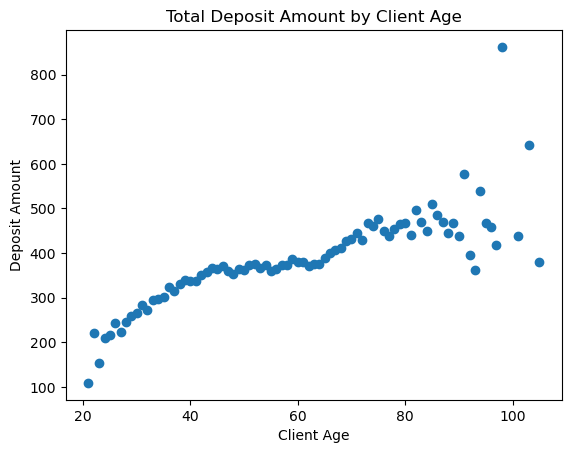

In [55]:
age_gp = agg_tbl.groupby('client_age')['deposit_amount'].mean().reset_index()

plt.scatter(data=age_gp, x='client_age', y='deposit_amount')
plt.xlabel('Client Age')
plt.ylabel('Deposit Amount')
plt.title('Total Deposit Amount by Client Age')
plt.show()

In [56]:
age_gp[(age_gp['client_age'] >= 30) & (age_gp['client_age'] <= 50)]


,client_age,deposit_amount
9,30,265.207295
10,31,283.667806
11,32,272.531799
12,33,294.916894
13,34,297.789780
14,35,301.578412
15,36,323.646259
16,37,315.482646
17,38,331.652574
18,39,339.533452


### 3). How do you think campaign performance would have changed if we did not run the campaign in Month 3, but instead postponed it until month 6? Provide an incremental number versus your result in Question #1.

A delay would have led to an additional uptick of about 10M, 12M, and 10M dollars of deposits in months 6, 7 and 8 when compared to month 5. This net 32M dollars represents and increment increase of about 5.5M dollars VS the results in question 1. More importantly, using the company website's 18% fees on deposits returned, the incremental 5.5M dollars results in an incremental 990K gross profit. Since the answer to question 1 resulted in a negative 200K return, the net return from postponing would now be about 790K. This campaign would then be profitable and should be pursued

One key business caveat would hinge on the increased opex from servicing more customers; The 752 new customers would likely require additional resourcing, possible headcount. A search on the internet reveals the average customer rep in NYC is paid between 50-66K annually. Assuming the cost of benefits, we can settle on 70K as the "all in loaded cost.

Thus, if we need to hire more than 11 new customer service reps, this campaign was unprofitable, and we should only pursue ventures in the future if we are confident they can lead to over 32M in deposits in the future OR we can more effectively allocate the costs (better self service systems, more efficient customer allocation process, etc)

In [57]:
"""
If we offset the effect of the campaign until month 6, we can proxy the impact by "postponing" new customer deposits from month 3 to month 6. Once we've done that, we can then compare the new month 6 value increase against the month 5 baseline.

In order to keep the comparison like for like with the analyses in question 1, we can add the incremental deposits in the new month 6, 7, and 8 to the average of months 1-5 to simulate how the delayed aquisition of new customers impacts the deposits growth

Steps:
1. find first time depositers in month 3 and offset their deposits by 90 days
2. recheck how deposits changed
"""

pre_camp = agg_tbl[(agg_tbl['month_name'] == 'Month 1') | (agg_tbl['month_name'] == 'Month 2')]['client_id'].unique()
during_camp = agg_tbl[(agg_tbl['month_name'] == 'Month 3')]['client_id'].unique()
post_camp = agg_tbl[(agg_tbl['month_name'] == 'Month 4') | (agg_tbl['month_name'] == 'Month 5')]['client_id'].unique()

camp_joiners = set(during_camp).difference(set(pre_camp))

post_camp_joiners = set(post_camp).difference(set(during_camp).union(set(pre_camp)))
len(post_camp_joiners)

752

In [58]:
def postpone(row):
    if row.client_id in camp_joiners:
        row.deposit_date = pd.to_datetime(row.deposit_date) + datetime.timedelta(days = 90)
        if row.month_name == 'Month 3':
            row.month_name = 'Month 6'
        elif row.month_name == 'Month 4':
            row.month_name = 'Month 7'
        elif row.month_name == 'Month 5':
            row.month_name = 'Month 8'
    else:
        row.deposit_date = pd.to_datetime(row.deposit_date)
    return row

In [59]:
offset_df = agg_tbl.copy(deep = True)


In [60]:
offset_df = offset_df.apply(func = postpone, axis = 1)

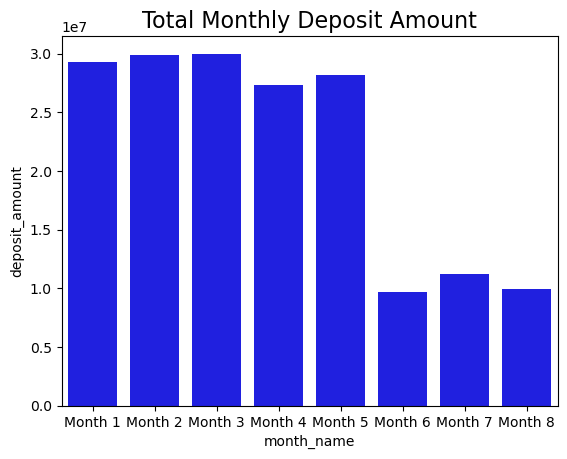

In [61]:
# check changes in total $ deposits over time 
mth_dep_amt = offset_df.groupby(offset_df['month_name'])['deposit_amount'].sum()

mth_dep_amt = mth_dep_amt.to_frame().reset_index()

sns.barplot(data=mth_dep_amt, x=mth_dep_amt['month_name'], y=mth_dep_amt['deposit_amount'], color="blue")
plt.title('Total Monthly Deposit Amount', fontsize =16)
plt.show()


In [62]:
"""
Since months 6-8 are synthetically dervied and don't have the baseline deposit data from months 1 -5, 
we can simulate that by using the average of months 1-5 deposits, and adding it to months 6-8 to proxy what would happen
"""
msk = (offset_df['month_name'] == 'Month 1') | (offset_df['month_name'] == 'Month 2') | \
    (offset_df['month_name'] == 'Month 3') | (offset_df['month_name'] == 'Month 4') | (offset_df['month_name'] == 'Month 5')


adj = (offset_df.groupby(offset_df[msk]['month_name'])['deposit_amount'].sum()).mean()


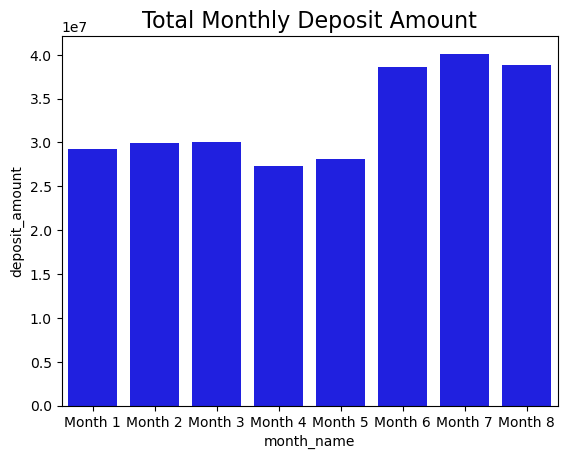

In [63]:
# check changes in total $ deposits over time WITH proxy baseline

mth_dep_amt = offset_df.groupby(offset_df['month_name'])['deposit_amount'].sum()

mth_dep_amt.at['Month 6'] += adj
mth_dep_amt.at['Month 7'] += adj
mth_dep_amt.at['Month 8'] += adj

mth_dep_amt = mth_dep_amt.to_frame().reset_index()


sns.barplot(data=mth_dep_amt, x=mth_dep_amt['month_name'], y=mth_dep_amt['deposit_amount'], color="blue")
plt.title('Total Monthly Deposit Amount', fontsize =16)
plt.show()

In [64]:
mth_dep_amt

,month_name,deposit_amount
0,Month 1,2.928483e+07
1,Month 2,2.988643e+07
2,Month 3,3.000242e+07
3,Month 4,2.730677e+07
4,Month 5,2.813815e+07
5,Month 6,3.859636e+07
6,Month 7,4.013277e+07
7,Month 8,3.886675e+07
